* X - Permit price and average price as function of baseline
* X - Weighted RRN price and average price as a function of baseline
* X - Weighted RRN price, average price, and price target - table
* X - Permit price and permit price target difference between them - table
* X - Change in relative costs for different types of generators - figure
* Regional price - map of australia - overlaid with blue or red dots - indicates magnitude of price change - subfigures - for different price targets
* X - Change in output from different types of generators - gas increase - coal decrease - for different baselines - emissions overlaid

# Process Results

In [1]:
import os
import re
import math
import pickle

import numpy as np
import pandas as pd
import geopandas as gp

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

Set text options

In [2]:
plt.rc('text', usetex=True)
matplotlib.rcParams['font.family'] = ['sans-serif']
matplotlib.rcParams['font.serif'] = ['Helvetica']

## Paths

In [3]:
# Data directory
data_dir = os.path.join(os.path.curdir, os.path.pardir, os.path.pardir, 'data')

# Scenario directory
scenarios_dir = os.path.join(os.path.curdir, os.path.pardir, '1_create_scenarios', 'output')

# Results directory
results_dir = os.path.join(os.path.curdir, os.path.pardir, '2_parameter_selector', 'kkt-approach', 'output')

# Output directory
output_dir = os.path.join(os.path.curdir, 'output')

## Load data

In [4]:
# Operating scenario data
with open(os.path.join(scenarios_dir, '2_scenarios.pickle'), 'rb') as g:
    scenarios = pickle.load(g)

# Network nodes
df_n = pd.read_csv(os.path.join(data_dir, 'egrimod-nem-dataset-v1.3', 'akxen-egrimod-nem-dataset-4806603', 'network', 'network_nodes.csv'), index_col='NODE_ID')

# Generator data
df_g = pd.read_csv(os.path.join(data_dir, 'egrimod-nem-dataset-v1.3', 'akxen-egrimod-nem-dataset-4806603', 'generators', 'generators.csv'), index_col='DUID')

Load and collate model result data in a single DataFrame.

In [5]:
class results_processor(object):
    "Process results from PYOMO model"
    
    def __init__(self, results_dir):
        # Path to directory containing model results
        self.results_dir = results_dir

    def scenario_results(self, scenario_name):
        """Collate DataFrame results from individual scenarios

        Param
        -----
        paths : list
            List of strings specifying paths to pickled files containing results

        Returns
        -------
        df_o : Pandas DataFrame
            Collated results for different emissions intensity baseline 
            scenarios in a single DataFrame.    
        """

        # Result files
        file_paths = [f for f in os.listdir(self.results_dir) if scenario_name in f]

        # Container for fixed emissions intensity baseline scenario results
        collated_results = list()

        for file in file_paths:
            with open(os.path.join(self.results_dir, file), 'rb') as f:
                result = pickle.load(f)

                # Check that DataFrame exists within result object
                if type(result['results']) != pd.core.frame.DataFrame:
                    raise Exception('Expected DataFrame, received: {}'.format(type(result['results'])))

                # Load DataFrame
                df = result['results']

                # Append values depending on the scenario being investigated
                # Discrete emissions intensity baseline value
                if 'PHI_DISCRETE' in result.keys():
                    df.loc['PHI_DISCRETE', 'Variable'] = [{'Value': result['PHI_DISCRETE']}]

                # Price targeting scenarios
                if 'WEIGHTED_RRN_PRICE_TARGET' in result.keys():
                    df['WEIGTHED_RRN_PRICE_TARGET'] = result['WEIGHTED_RRN_PRICE_TARGET']
                
                if 'WEIGHTED_RRN_PRICE_TARGET_BAU_MULTIPLE' in result.keys():
                    df['WEIGHTED_RRN_PRICE_TARGET_BAU_MULTIPLE'] = result['WEIGHTED_RRN_PRICE_TARGET_BAU_MULTIPLE']

                # Fixed baseline scenarios
                if 'FIXED_BASELINE' in result.keys():
                    df['FIXED_BASELINE'] = result['FIXED_BASELINE']
                    
                # Permit price targeting scenario
                if 'PERMIT_PRICE_TARGET' in result.keys():
                    df['PERMIT_PRICE_TARGET'] = result['PERMIT_PRICE_TARGET']

                # Collate results
                collated_results.append(df)

        # Collated results        
        df_o = pd.concat(collated_results)            

        return df_o
    
    
    def formatted_results(self, scenario_name):
        "Format scenario results by extracting variable and index names"
    
        # Compiled scenario results
        df = self.scenario_results(scenario_name)
    
        # Function used in apply statement to extract variable indices from DataFrame index
        def _extract_index(row):
            "Extract variable indices"

            # Scenario inidices
            # -----------------
            # Extract from index
            scenario_indices = re.findall(r'SCENARIO\[(\d)+\]', row.name)

            # Expect either 1 or 0 values for scenario index
            if len(scenario_indices) == 1:
                scenario_index = int(scenario_indices[0])

            # Raise exception if more than one scenario index encountered
            elif len(scenario_indices) > 1:
                raise(Exception('Only expected 1 scenario index to have one element: {0}'.format(scenario_indices)))
                scenario_index = np.nan

            # If no scenario index, set to null value
            else:
                scenario_index = np.nan


            # Variable indices   
            # ----------------
            # Extract all variable indices from index. Expect at most 2 indices.
            variable_indices = re.findall(r'(?<!SCENARIO)\[([\w\d\,\-\#]+)\]', row.name)

            # Empty list = no variable indices - set to null values
            if len(variable_indices) == 0:
                variable_index_1 = np.nan
                variable_index_2 = np.nan

            elif len(variable_indices) == 1:
                # Split variable indices if separated comma
                variable_indices_split = variable_indices[0].split(',')

                # If no variable indices found, set both to null values
                if len(variable_indices_split) == 0:
                    variable_index_1 = np.nan
                    variable_index_2 = np.nan

                # If only 1 variable index found
                elif len(variable_indices_split) == 1:
                    variable_index_1 = variable_indices_split[0]
                    variable_index_2 = np.nan

                # If 2 variable indices found
                elif len(variable_indices_split) == 2:
                    variable_index_1, variable_index_2 = variable_indices_split

                # Else unexpected number of variable indices encountered (more than 2). Raise exception.
                else:
                    raise(Exception('Unexpected number of variable indices encountered for {0}'.format(variable_indices_split)))

            else:
                raise(Exception('Unexpected number of index components: {0}'.format(variable_indices)))

            # Handle variable name
            if '.' not in row.name:
                if '[' in row.name:
                    variable_name = re.findall(r'(.+)\[', row.name)[0]
                else:
                    variable_name = row.name
            else:
                regex = r'\.(.+)\['
                variable_names = re.findall(regex, row.name)

                if variable_names:           
                    variable_name = variable_names[0]
                else:
                    variable_name = np.nan

            return pd.Series(data={'variable_name': variable_name, 'scenario_index': scenario_index, 'variable_index_1': variable_index_1, 'variable_index_2': variable_index_2})

        # DataFrame with extracted indices
        df[['variable_name', 'scenario_index', 'variable_index_1', 'variable_index_2']] = df.apply(_extract_index, axis=1)
        
        return df

# Instantiate results processor object
results_processor = results_processor(results_dir=results_dir)

## Process results from different scenarios

In [6]:
# # Fixed emissions intensity baseline
# # ----------------------------------
# df_fixed_baseline = results_processor.formatted_results(scenario_name='fixed_baseline')

# # Save DataFrame
# with open(os.path.join(output_dir, 'tmp', 'df_fixed_baseline.pickle'), 'wb') as f:
#     pickle.dump(df_fixed_baseline, f)


# # Weighted Regional Reference Node (RRN) price targeting
# # ------------------------------------------------------
# df_weighted_rrn_price_target = results_processor.formatted_results(scenario_name='weighted_rrn_price_target')

# # Save DataFrame
# with open(os.path.join(output_dir, 'tmp', 'df_weighted_rrn_price_target.pickle'), 'wb') as f:
#     pickle.dump(df_weighted_rrn_price_target, f)
    

# # Permit price targeting scenarios
# # --------------------------------
# df_permit_price_target = results_processor.formatted_results(scenario_name='permit_price_target')

# # Save DataFrame
# with open(os.path.join(output_dir, 'tmp', 'df_permit_price_target.pickle'), 'wb') as f:
#     pickle.dump(df_permit_price_target, f)

Load data if processed previously (save time).

In [7]:
# Fixed baseline scenarios
with open(os.path.join(output_dir, 'tmp', 'df_fixed_baseline.pickle'), 'rb') as f:
    df_fixed_baseline = pickle.load(f)
    
# Permit price targeting scenarios
with open(os.path.join(output_dir, 'tmp', 'df_permit_price_target.pickle'), 'rb') as f:
    df_permit_price_target = pickle.load(f)

# Weighted Regional Reference Node (RRN) price targeting scenarios
with open(os.path.join(output_dir, 'tmp', 'df_weighted_rrn_price_target.pickle'), 'rb') as f:
    df_weighted_rrn_price_target = pickle.load(f)

## Exploratory plots
### Fixed emissions intensity baseline scenarios
#### Permit price as a function of the emissions intensity baseline

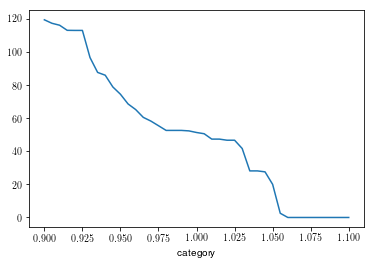

In [8]:
def permit_price_vs_baseline(df, category):
    """Permit price as a function of emissions intensity baseline
    
    Parameters
    ----------
    df : pandas DataFrame
        Input dataframe containing collated scenario results
    
    category : str
        Name of colum which is used to differentiate between scenarios
        e.g. FIXED_BASELINE
        
    Returns
    -------
    df_o : pandas Series
        Permit price corresponding to different scenarios    
    """
    
    # Permit price as a function of emissions intensity baseline
    # Note: Scaling by factor of 100 to take into account prior normalisation
    df_o = (df.loc[df['variable_name']=='tau']
            .apply(lambda x: pd.Series({'tau': x['Variable']['Value'] * 100, 'category': x[category]}), axis=1)
            .set_index('category')['tau'])
    
    return df_o

# Permit price as a function of emissisons intensity baseline
df_tau = permit_price_vs_baseline(df_fixed_baseline, category='FIXED_BASELINE')

plt.clf()
df_tau.plot()
plt.show()

#### Average wholesale price as a function of the emissions intensity baseline

In [9]:
def get_average_prices(df, category):
    """Compute average electricity price for NEM regions and also for the nation
    
    Parameters
    ----------
    df : pandas DataFrame
        Input dataframe containing collated scenario results
    
    category : str
        Name of colum which is used to differentiate between scenarios
        e.g. FIXED_BASELINE
        
    Returns
    -------
    df_o : pandas Series
        Average prices for different scenarios for each NEM region and also at the national level
    """

    def _node_revenue_and_demand(row):
        "Compute node revenue and demand for each node for each scenario"

        # Node ID
        node = int(row['variable_index_1'])

        # Scenario ID
        scenario = int(row['scenario_index'])

        # Duration of given scenario [hours]
        duration = scenarios.loc[('hours', 'duration'), scenario]

        # Energy demand at node for given scenario [MWh]
        demand_mwh = scenarios.loc[('demand', node), scenario] * duration

        # Nodal price taking into account data processing normalisation
        price = row['Variable']['Value'] * 100

        # Nodal revenue [$]
        node_revenue = price * demand_mwh

        return pd.Series({'node_revenue': node_revenue, 'demand_mwh': demand_mwh, 'node': node, category: row[category]})

    # Filter so only price records remain and then compute revenue and demand for each node and scenario
    df_rp = df.loc[df['variable_name']=='lamb'].apply(_node_revenue_and_demand, axis=1)
    
    # Merge node information
    df_rp = pd.merge(df_rp, df_n[['RRN', 'NEM_REGION']], how='left', left_on='node', right_index=True)
    
    # Average prices by NEM region for different baselines
    df_regional_prices = df_rp.groupby(['NEM_REGION', category])[['demand_mwh', 'node_revenue']].sum().apply(lambda x: x['node_revenue'] / x['demand_mwh'], axis=1)

    # National average prices
    df_national_prices = df_rp.groupby([category])[['demand_mwh', 'node_revenue']].sum().apply(lambda x: x['node_revenue'] / x['demand_mwh'], axis=1)

    # Add level to index
    df_national_prices.index = pd.MultiIndex.from_tuples([('NATIONAL', b) for b in df_national_prices.index])

    # Average wholesale prices
    df_o = pd.concat([df_regional_prices, df_national_prices])
    
    return df_o

# Average electricity prices for different emissions intensity baselines
df_average_prices = get_average_prices(df_fixed_baseline, category='FIXED_BASELINE')

# plt.clf()
# df_average_prices.loc['NATIONAL'].plot()
# plt.show()

#### Regional price impacts for different baselines

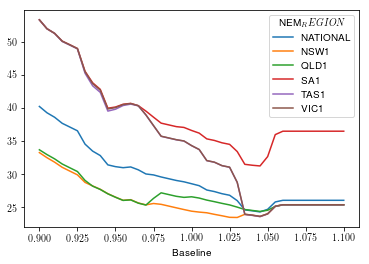

In [10]:
(df_average_prices
 .reset_index()
 .pivot(index='FIXED_BASELINE', columns='NEM_REGION', values=0)
 .reset_index().rename(columns={'FIXED_BASELINE': 'Baseline', 'NEM_REGION':'Region'})
 .set_index('Baseline').plot())
plt.show()

#### Weighted Regional Reference Node (RRN) prices

In [11]:
def get_weighted_rrn_prices(df, category):
    """Compute weighted RRN prices for each baseline scenario
    
    Parameters
    ----------
    df : pandas DataFrame
        Input dataframe containing collated scenario results
    
    category : str
        Name of colum which is used to differentiate between scenarios
        e.g. FIXED_BASELINE
        
    Returns
    -------
    df_o : pandas Series
        Weighted RRN prices for each scenario
    """ 

    # Demand in each NEM region
    region_demand = (scenarios.loc[('demand', slice(None)), :]
                     .reset_index()
                     .set_index('NODE_ID')
                     .join(df_n[['NEM_REGION']], how='left')
                     .groupby('NEM_REGION').sum())

    # Normalised demand - used to weight RRN prices
    rrn_demand_weights = region_demand.div(region_demand.sum())

    # Normalised duration - used to weight RRN prices
    rrn_duration_weights = (scenarios.loc[('hours', 'duration')]
                            .div(scenarios.loc[('hours', 'duration')]
                                 .sum()).to_frame().T)

    # Prices at all nodes
    df_o = df[df['variable_name']=='lamb'].copy()

    # Convert node ID to type int
    df_o.loc[:, 'variable_index_1'] = df_o['variable_index_1'].astype(int)

    # Add region and RRN information
    df_o = pd.merge(df_o, df_n[['NEM_REGION', 'RRN']], how='left', left_on='variable_index_1', right_index=True)

    # Filter so only Regional Reference Nodes (RRNs) remain
    df_o = df_o[df_o['RRN']==1]

    # Weighted RRN prices
    def _weight_rrn_prices(row):
        "Weight RRN prices so they can act as a proxy for average wholesale prices"

        # Normalised duration
        normalised_duration = rrn_duration_weights.loc[('hours', 'duration'), row['scenario_index']]

        # RRN price - scaled by factor of 100 to take into account prior normalisation
        rrn_price = float(row['Variable']['Value']) * 100

        # Normalised demand
        normalised_region_demand = rrn_demand_weights.loc[row['NEM_REGION'], row['scenario_index']]

        return rrn_price * normalised_duration * normalised_region_demand

    df_o['weighted_prices'] = df_o.apply(_weight_rrn_prices, axis=1)

    df_o = df_o.groupby(category)['weighted_prices'].sum()
    
    return df_o

# Weighted RRN prices for different fixed baseline scenarios
df_weighted_rrn_prices = get_weighted_rrn_prices(df_fixed_baseline, category='FIXED_BASELINE')

#### Generator output by technology type

In [12]:
def _get_generator_output(row):
    # DUID
    duid = row['variable_index_1']
    
    # Duration of given scenario [hours]
    duration = scenarios.loc[('hours', 'duration'), row['scenario_index']]
    
    # Average power output during scenario
    power_output = float(row['Variable']['Value'])
    
    # Energy output - scale by factor of 100 to take into account prior normalisation [MWh]
    energy_output = power_output * duration * 100
    
    # Emissions [tCO2]
    emissions = energy_output * df_g.loc[duid, 'EMISSIONS']
    
    return pd.Series({'energy_output': energy_output,
                      'DUID': duid,
                      'scenario_index': row['scenario_index'],
                      'FIXED_BASELINE': row['FIXED_BASELINE'],
                      'emissions': emissions})

df_generator_output = df_fixed_baseline.loc[df_fixed_baseline['variable_name']=='p'].apply(_get_generator_output, axis=1)   

## Manuscript Plots
Parameters common to all plots.

In [13]:
fontsize = 9
labelsize = 8

#### Weighted RRN prices and permit prices
Format data for plotting.

In [14]:
# Extract key values and place into DataFrame
df_1 = df_weighted_rrn_price_target.loc['PHI_DISCRETE'].apply(lambda x: pd.Series({'PHI_DISCRETE': x['Variable']['Value'], 'WEIGHTED_RRN_PRICE_TARGET_BAU_MULTIPLE': x['WEIGHTED_RRN_PRICE_TARGET_BAU_MULTIPLE'], 'WEIGTHED_RRN_PRICE_TARGET': x['WEIGTHED_RRN_PRICE_TARGET'] * 100}), axis=1)

# Average BAU price
bau_price = df_average_prices.loc['NATIONAL'].iloc[-1]

# Add actual average wholesale prices from scenario
df_1_prices = get_average_prices(df_weighted_rrn_price_target, category='WEIGHTED_RRN_PRICE_TARGET_BAU_MULTIPLE')
df_1 = pd.merge(df_1, 
                df_1_prices.loc['NATIONAL'].div(bau_price).to_frame().rename(columns={0: 'AVERAGE_PRICE_BAU_MULTIPLE'}),
                left_on='WEIGHTED_RRN_PRICE_TARGET_BAU_MULTIPLE',
                right_index=True)

# Permit price targeting scenarios
df_2 = df_permit_price_target.groupby('PERMIT_PRICE_TARGET')[['Variable']].apply(lambda x: x.loc[['tau', 'PHI_DISCRETE']]).unstack().applymap(lambda x: x['Value'])
df_2.columns = df_2.columns.droplevel(0)

# Multiply by 100 to account for prior normalisation
df_2['tau'] = df_2['tau'].mul(100)

Construct plot.

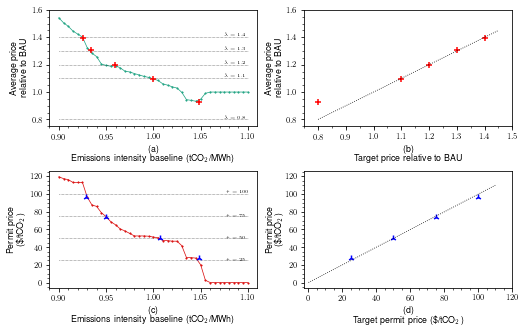

In [15]:
plt.clf()

# Initialise figure
# -----------------
fig = plt.figure()
ax1 = plt.axes([0.09, 0.62, 0.4, 0.36]) # Average price series
ax2 = plt.axes([0.58, 0.62, 0.4, 0.36]) # Average price and target price error
ax3 = plt.axes([0.09, 0.12, 0.4, 0.36]) # Permit price series
ax4 = plt.axes([0.58, 0.12, 0.4, 0.36]) # Permit price and target error


# Average wholesale prices
# ------------------------
# Average price for each fixed baseline scenario
ax1.plot(df_average_prices.loc['NATIONAL'].div(bau_price).index,
         df_average_prices.loc['NATIONAL'].div(bau_price).values, 
         linestyle='-',
         color='#24a585',
         marker='o',
         markersize=1.5,
         linewidth=0.75,
         markeredgewidth=0.5)

# Baselines for given weighted RRN price target
ax1.scatter(df_1['PHI_DISCRETE'], df_1['AVERAGE_PRICE_BAU_MULTIPLE'],
            color='red', marker='+', zorder=3)

# Horizontal lines denoting price targets
for index, row in df_1.iterrows():
    ax1.plot([0.9, 1.1], [row['WEIGHTED_RRN_PRICE_TARGET_BAU_MULTIPLE'], row['WEIGHTED_RRN_PRICE_TARGET_BAU_MULTIPLE']], linestyle=':', linewidth=0.5, color='k')

# Add label to horizontal lines specifying average price target
ax1.text(1.075, 1.405, '$\hat{\lambda} = 1.4$', fontsize=fontsize-4)
ax1.text(1.075, 1.305, '$\hat{\lambda} = 1.3$', fontsize=fontsize-4)
ax1.text(1.075, 1.205, '$\hat{\lambda} = 1.2$', fontsize=fontsize-4)
ax1.text(1.075, 1.105, '$\hat{\lambda} = 1.1$', fontsize=fontsize-4)
ax1.text(1.075, 0.805, '$\hat{\lambda} = 0.8$', fontsize=fontsize-4)

# Format axes
ax1.set_ylabel('Average price \n relative to BAU', fontsize=fontsize)
ax1.set_xlabel('(a) \n Emissions intensity baseline (tCO$_{2}$/MWh)', fontsize=fontsize)

# Format ticks
ax1.minorticks_on()
majorLocator = MultipleLocator(0.2)
ax1.yaxis.set_major_locator(majorLocator)
ax1.tick_params(axis='x', labelsize=labelsize)
ax1.tick_params(axis='y', labelsize=labelsize)


# Difference between target and outcome - weighted RRN prices
# -----------------------------------------------------------
# Share common y-axis
ax2.get_shared_y_axes().join(ax2, ax1)

# Weighted RRN prices and their corresponding price targets
ax2.scatter(df_1['WEIGHTED_RRN_PRICE_TARGET_BAU_MULTIPLE'], df_1['AVERAGE_PRICE_BAU_MULTIPLE'], marker='+', color='r')

# Straight line with slope = 1
ax2.plot([0.8, 1.45], [0.8, 1.45], linestyle=':', linewidth=0.8, color='black')

# Set axis limits
ax2.set_ylim(0.75, 1.6)
ax2.set_xlim(0.75, 1.5)

# Set axes labels
ax2.set_xlabel('(b)\nTarget price relative to BAU', fontsize=fontsize)
ax2.set_ylabel('Average price\nrelative to BAU', fontsize=fontsize)

# Format ticks
ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=8)

majorLocator = MultipleLocator(0.2)
ax2.yaxis.set_major_locator(majorLocator)

majorLocator = MultipleLocator(0.1)
ax2.xaxis.set_major_locator(majorLocator)

minorLocator = MultipleLocator(0.05)
ax2.xaxis.set_minor_locator(minorLocator)

ax2.tick_params(axis='x', labelsize=labelsize)
ax2.tick_params(axis='y', labelsize=labelsize)

ax2.tick_params(axis='x', labelsize=labelsize)
ax2.tick_params(axis='y', labelsize=labelsize)


# Permit price profile
# --------------------
ax3.get_shared_x_axes().join(ax3, ax1)

for index, row in df_2.iterrows():
    ax3.plot([0.9, 1.1], [index * 100, index * 100], linestyle=':', linewidth=0.5, color='k')

# Permit prices
df_tau.plot(ax=ax3,
            linestyle='-',
            color='#db1313',
            marker='o',
            markersize=1.5,
            linewidth=0.75,
            markeredgewidth=0.5)

ax3.scatter(df_2['PHI_DISCRETE'], df_2['tau'], color='blue', marker='2', zorder=3)

ax3.set_ylim([-5, 140])

# Set axes labels
ax3.set_ylabel('Permit price \n (\$/tCO$_{2}$)', fontsize=fontsize)
ax3.set_xlabel('(c) \n Emissions intensity baseline (tCO$_{2}$/MWh)', fontsize=fontsize)

# Format ticks
ax3.minorticks_on()
ax3.tick_params(axis='x', labelsize=labelsize)
ax3.tick_params(axis='y', labelsize=labelsize)

# Add permit price target labels to horizontal lines
ax3.text(1.077, 100.5, r'$\hat{\tau} = 100$', fontsize=fontsize-4)
ax3.text(1.077, 75.5, r'$\hat{\tau} = 75$', fontsize=fontsize-4)
ax3.text(1.077, 50.5, r'$\hat{\tau} = 50$', fontsize=fontsize-4)
ax3.text(1.077, 25.5, r'$\hat{\tau} = 25$', fontsize=fontsize-4)


# Difference between permit price and target
# ------------------------------------------
ax4.get_shared_y_axes().join(ax4, ax3)
ax4.scatter(df_2.reset_index()['PERMIT_PRICE_TARGET'].mul(100), df_2['tau'], marker='2', color='blue')

# Line with slope = 1
ax4.plot([0, 110], [0, 110], linestyle=':', linewidth=0.8, color='black')

# Format labels
ax4.set_ylabel('Permit price\n(\$/tCO$_{2}$)', fontsize=fontsize, labelpad=0.5)
ax4.set_xlabel('(d)\nTarget permit price (\$/tCO$_{2}$)', fontsize=fontsize)

# Format ticks
ax4.minorticks_on()
ax4.tick_params(axis='x', labelsize=labelsize)
ax4.tick_params(axis='y', labelsize=labelsize)

# Set axis limits
ax4.set_xlim(-2.5, 120)

# Set figure size
fig.set_size_inches(7.22433, 3.48761+1)
fig.savefig(os.path.join(output_dir, 'figures', 'target_prices.pdf'))

plt.show()

#### Comparison between weighted RRN price and average price
See how well weighted RRN prices correspond with average prices.

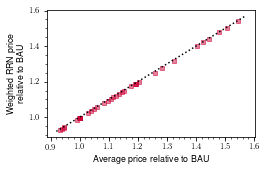

In [16]:
plt.clf()

# Initialise figure
fig, ax1 = plt.subplots()

# Average price (x-axis) vs weighted RRN price (y-axis)
ax1.scatter(df_average_prices.loc['NATIONAL'].div(bau_price), df_weighted_rrn_prices.div(bau_price),
            marker='s',
            color='#ce0037',
            alpha=0.5,
            s=10)

# Line with slope = 1
ax1.plot([0.92, 1.57], [0.92, 1.57], linestyle=':', color='k')

# Axes labels
ax1.set_xlabel('Average price relative to BAU', fontsize=fontsize)
ax1.set_ylabel('Weighted RRN price\nrelative to BAU', fontsize=fontsize)

# Format ticks
ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=labelsize)
ax1.tick_params(axis='y', labelsize=labelsize)

# Set figure size
fig.set_size_inches(7.22433/2, (7.22433/2) / 1.61803398875)
fig.subplots_adjust(left=0.17, bottom=0.18, right=0.97, top=0.97)

# Save figure
fig.savefig(os.path.join(output_dir, 'figures', 'weighted_rrn_prices_average_price_comparison.pdf'))
plt.show()

### Impact of baseline on SRMCs and energy output for different technologies

In [17]:
def construct_srmc_comparison(df_tau, df_g, fuel_types):
    """Compare SRMCs for different generators for different baselines
    
    Parameters
    ----------
    df_tau : pandas Series
        Permit prices for different emissions intensity baselines
    
    df_g : pandas DataFrame
        Generator parameters. e.g. SRMCs and emissions intensities
        
    fuel_types : list
        List of fuel types for which the comparison should be carried out
    
    Returns
    -------
    means : pandas DataFrame
        Contains mean SRMCs for different fuel types and emissions intensity baselines
    
    errors : pandas DataFrame
        SRMC standard deviations for different fuel types and emissions intensity baselines
    """
    
    # Container for SRMC DataFrames
    dfs = []

    # Loop through each fixed baseline scenario
    for index, row in df_tau.iteritems():
        # Compute udpated SRMCs
        s_srmc = df_g['SRMC_2016-17'] + (df_g['EMISSIONS'] - index) * row

        # Format columns and add fixed baseline and tau to indentify scenario
        df_srmc = s_srmc.to_frame().rename(columns={0: 'SRMC'})
        df_srmc['FIXED_BASELINE'] = index
        df_srmc['tau'] = row

        # Append to DataFrame container
        dfs.append(df_srmc)

    # Concatenate DataFrames. Compute mean and standard deviation for SRMCs for generators of different fuel types
    df = (pd.concat(dfs)
          .drop('tau', axis=1)
          .join(df_g[['FUEL_TYPE', 'REG_CAP']], how='left')
          .groupby(['FIXED_BASELINE', 'FUEL_TYPE'])
          .apply(lambda x: pd.Series({'mean': x['SRMC'].mean(), 'weighted_mean': x['SRMC'].mul(x['REG_CAP'].div(x['REG_CAP'].sum())).sum(), 'max': x['SRMC'].max(), 'min': x['SRMC'].min(), 'std': x['SRMC'].std()})))

    # Maximum SRMC for generators of each fuel type
    max_srmcs = df[df.index.get_level_values(1).isin(fuel_types)].reset_index().pivot(index='FIXED_BASELINE', columns='FUEL_TYPE', values='max')

    # Minimum SRMC for generators of each fuel type
    min_srmcs = df[df.index.get_level_values(1).isin(fuel_types)].reset_index().pivot(index='FIXED_BASELINE', columns='FUEL_TYPE', values='max')

    # Mean SRMC
    means = df[df.index.get_level_values(1).isin(fuel_types)].reset_index().pivot(index='FIXED_BASELINE', columns='FUEL_TYPE', values='mean')
    
    # Weighted mean SRMC for selected generators (SRMCs weighted by installed capacity for each fuel type)
    weighted_means = df[df.index.get_level_values(1).isin(fuel_types)].reset_index().pivot(index='FIXED_BASELINE', columns='FUEL_TYPE', values='weighted_mean')

    # Standard deviation
    std_srmcs = df[df.index.get_level_values(1).isin(fuel_types)].reset_index().pivot(index='FIXED_BASELINE', columns='FUEL_TYPE', values='std')

    return means, weighted_means, max_srmcs, min_srmcs, std_srmcs

means, weighted_means, max_srmcs, min_srmcs, std_srmcs = construct_srmc_comparison(df_tau, df_g, ['Black coal', 'Brown coal', 'Natural Gas (Pipeline)'])

Plot SRMC bands (maximum and minimum) SRMCs for each main generating technology over a range of emissions intensity baselines.

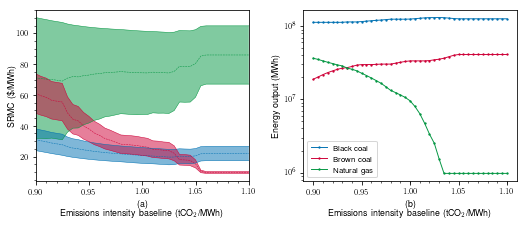

In [18]:
plt.clf()

# SRMC ranges for different generating technologies
# -------------------------------------------------
# Initialise figure
fig = plt.figure()
ax1 = plt.axes([0.065, 0.18, 0.41, 0.8]) # Average price series
ax2 = plt.axes([0.58, 0.18, 0.41, 0.8]) # Average price and target price error

# Colours associated with each generating technology
s = pd.Series(['#0071b2', '#ce0037', '#039642'], index=['Black coal', 'Brown coal', 'Natural Gas (Pipeline)'])

# Mean, max, and min SRMCs for different generating technologies
means.plot(ax=ax1, color=s, alpha=1, style='--', legend=False, linewidth=0.5)
means.add(std_srmcs).plot(ax=ax1, style='-', color=s, legend=False, alpha=1, linewidth=0.5)
means.subtract(std_srmcs).plot(ax=ax1, style='-', color=s, legend=False, alpha=1, linewidth=0.5)

# Fill line between upper and lower standard deviation and mean SRMC
ax1.fill_between(means.index, means.subtract(std_srmcs)['Natural Gas (Pipeline)'], means.add(std_srmcs)['Natural Gas (Pipeline)'], facecolor='#039642', alpha=0.5)
ax1.fill_between(means.index, means.subtract(std_srmcs)['Black coal'], means.add(std_srmcs)['Black coal'], facecolor='#0071b2', alpha=0.5)
ax1.fill_between(means.index, means.subtract(std_srmcs)['Brown coal'], means.add(std_srmcs)['Brown coal'], facecolor='#ce0037', alpha=0.5)

# Axes labels
ax1.set_xlabel('(a)\nEmissions intensity baseline (tCO$_{2}$/MWh)', fontsize=fontsize)
ax1.set_ylabel('SRMC (\$/MWh)', labelpad=-0.1, fontsize=fontsize)

# Format tick labels
ax1.minorticks_on()
ax1.tick_params(axis='x', labelsize=labelsize)
ax1.tick_params(axis='y', labelsize=labelsize)

# Set axes limits
ax1.set_xlim(0.9, 1.1)
# ax1.set_ylim(0, 120)


# Change in output
# ----------------
# Plot energy output for different technologies
(pd.merge(df_generator_output, df_g[['NEM_REGION', 'FUEL_TYPE', 'FUEL_CAT']], 
          how='left', left_on='DUID', right_index=True)
 .groupby(['FUEL_TYPE', 'FIXED_BASELINE'])['energy_output']
 .sum().reset_index()
 .pivot(index='FIXED_BASELINE',
        columns='FUEL_TYPE',
        values='energy_output')[['Black coal', 'Brown coal', 'Natural Gas (Pipeline)']]
 .plot(logy=True, color=s, legend=False, marker='o', markersize=1.3, linewidth=0.95, ax=ax2))

# Construct legend
ax2.legend(['Black coal', 'Brown coal', 'Natural gas'], fontsize=labelsize)

# Format axes labels
ax2.set_xlabel('(b)\nEmissions intensity baseline (tCO$_{2}$/MWh)', fontsize=fontsize)
ax2.set_ylabel('Energy output (MWh)', fontsize=fontsize)

# Format ticks
ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=labelsize)
ax2.tick_params(axis='y', labelsize=labelsize)

majorLocator = MultipleLocator(0.05)
ax2.xaxis.set_major_locator(majorLocator)

# Format figure size
fig.set_size_inches(7.22433, (7.22433 / 1.61803398875)/1.5)
fig.subplots_adjust(left=0.125, bottom=0.175, right=0.955, top=0.905)

# Save figure
fig.savefig(os.path.join(output_dir, 'figures', 'srmc_and_output_vs_baseline.pdf'))
plt.show()

### Emissions intensity range for generator types

In [19]:
df_g[df_g['FUEL_CAT'] == 'Fossil'].groupby('FUEL_TYPE').apply(lambda x: pd.Series({'min': x['EMISSIONS'].min(), 'max': x['EMISSIONS'].max()})).drop(['Coal seam methane', 'Diesel oil', 'Kerosene - non aviation']).rename(index={'Natural Gas (Pipeline)': 'Gas'})

,min,max
FUEL_TYPE,,
Black coal,0.89209,1.04950
Brown coal,1.23230,1.44707
Gas,0.44079,1.35599


### Generator capacities by fuel type relative to total generating capacity in system

In [20]:
df_g.groupby('FUEL_TYPE').apply(lambda x: x['REG_CAP'].sum() / df_g.loc[:, 'REG_CAP'].sum())

FUEL_TYPE
Black coal                 0.407842
Brown coal                 0.104187
Coal seam methane          0.022726
Diesel oil                 0.006553
Hydro                      0.166633
Kerosene - non aviation    0.010419
Natural Gas (Pipeline)     0.208131
Solar                      0.004710
Wind                       0.068799
dtype: float64

In [26]:
df_g.groupby('FUEL_TYPE').apply(lambda x: x['EMISSIONS'].mul(x['REG_CAP']).div(x['REG_CAP'].sum()).sum())

FUEL_TYPE
Black coal                 0.969727
Brown coal                 1.312538
Coal seam methane          0.680728
Diesel oil                 1.099717
Hydro                      0.000000
Kerosene - non aviation    1.001553
Natural Gas (Pipeline)     0.688529
Solar                      0.000000
Wind                       0.000000
dtype: float64